<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/intro/supervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
#@title
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']

cmap = ListedColormap(colors)

# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
random_seed = 42
tf.random.set_seed(random_seed)

import numpy as np
np.random.seed(random_seed)

import pandas as pd

# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/
# https://matplotlib.org/gallery/images_contours_and_fields/contourf_demo.html

from matplotlib.ticker import FuncFormatter

def meshGrid(x_data=None, y_data=None):
    h = 1  # step size in the mesh
    x_min, x_max = 10, 110
    y_min, y_max = 80, 170
#     x_min, x_max = x_data.min() - 1, x_data.max() + 1
#     y_min, y_max = y_data.min() - 1, y_data.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return (xx,yy)

def plot_samples(samples, ax, legend):
    classes = samples[2]
    scatter = ax.scatter(samples[0], samples[1], c=classes, cmap=cmap, s=50, marker='o', edgecolors='k')

    # https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/scatter_with_legend.html
    formatter = FuncFormatter(lambda s,t: "Many Accidents" if s == 0 else "No Accidents" if s == 1 else "Few Accidents")
    class_legend = ax.legend(*scatter.legend_elements(alpha=0.6, prop='colors', fmt=formatter), title="Classes")
    ax.add_artist(class_legend)
    
    return ax, scatter

def plot_samples_markers(samples, ax, legend):
  y = samples[2]
  bad = samples[y == 0]
  good = samples[y == 1]
  fair = samples[y == 2]

  labels = ["High Risk", "Low Risk", "Medium Risk"]
  classes = [bad, good, fair]
  markers = ['v', 'd', '^']

  for label, clazz, color, marker in zip(labels, classes, colors, markers):
      ax.scatter(
          clazz[0], 
          clazz[1],
          label=label,
          color=color,
          marker=marker,
          s=100,
          edgecolors='k',
          alpha=0.8)
  if legend:
    ax.legend()
  return ax, None
      

def plotPrediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                   n_samples=None, proba=True, prediction=True, legend=True, 
                   scatter=True,
                   X=None,
                   ax=None
                  ):
    if x_data is not None:
      assert x_data.shape == y_data.shape, "x and y must have the same dimension"
    if x_data  is not None and ground_truth is not None:
      assert x_data.shape == ground_truth.shape, "input and ground truth need the same number of samples"
    xx,yy = meshGrid(x_data, y_data)
    if ax is None:
      fig, ax = plt.subplots()

    if clf:
        if X is not None:
          Z = clf.predict_proba(X)
        else:
          Z = clf.predict_proba(np.c_[yy.ravel(), xx.ravel()])

        if proba:
            probaZ = Z.max(axis=1)
            probaZ = probaZ.reshape(xx.shape)
            ax.contourf(xx, yy, probaZ, cmap=plt.cm.binary, alpha=.4)

        if prediction:
            Z = Z.argmax(axis=1)
            Z = Z.reshape(xx.shape)
            ax.contourf(xx, yy, Z, cmap=cmap, alpha=.3)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    
    if scatter:
      samples = pd.DataFrame(np.array([x_data, y_data, ground_truth]).T)
      if n_samples:
        samples = samples.sample(n_samples, random_state=42)
      plot_samples_markers(samples, ax, legend)
    return ax 



# Exericse I: Getting familiar with Colab Notebooks

* notebooks are made up out of text and code cells
* they can be executed in any order, but are typically supposed to be executed in order
* execute cells by clicking into them and then type shift+return
* execute all the code cells until you see "stop here"


# Loading and exploring our data set

This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved with in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [41]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   287k      0 --:--:-- --:--:-- --:--:--  290k


In [42]:
!head insurance-customers-1500.csv

speed;age;miles;group
98.0;44.0;25.0;1
118.0;54.0;24.0;1
111.0;26.0;34.0;0
97.0;25.0;10.0;2
114.0;38.0;22.0;1
130.0;55.0;34.0;0
118.0;40.0;51.0;0
143.0;42.0;34.0;1
120.0;41.0;42.0;2


In [43]:
import pandas as pd
df = pd.read_csv('./insurance-customers-1500.csv', sep=';') 

In [44]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [45]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [46]:
vars = ['speed', 'age', 'miles']

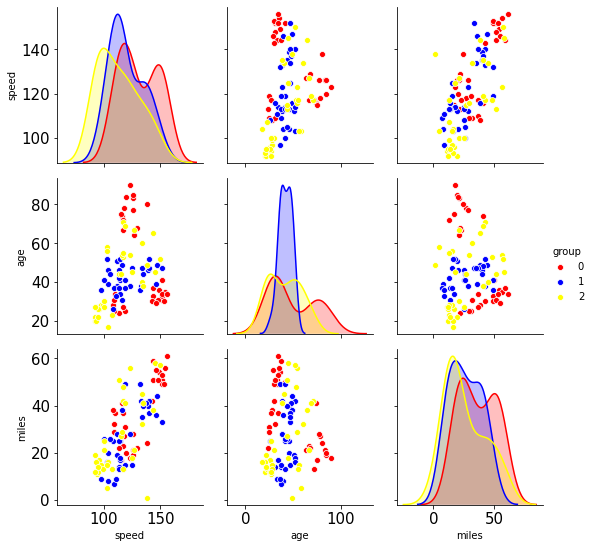

In [47]:
import seaborn as sns

sample_df = df.sample(n=100, random_state=42)
sns.pairplot(sample_df, hue="group", kind="scatter", diag_kind="kde", vars=vars, palette={0: '#FF0000', 1: '#0000FF', 2: '#FFFF00'});

In [48]:
cm = df.corr()
cm.shape

(4, 4)

In [49]:
cm3 = cm.iloc[:3, :3]
cm3.shape

(3, 3)

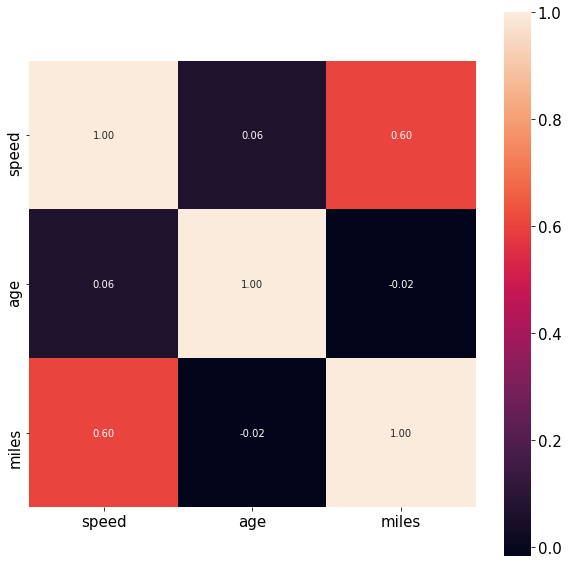

In [50]:
plt.figure(figsize=(10, 10))
hm = sns.heatmap(cm3,
                cbar=True,
                annot=True,
                square=True,
                fmt='.2f',
                yticklabels=vars,
                xticklabels=vars)
# plt.savefig('cm.png', transparent=True)

# Stop here

# Exericse II: Select features and train your first model

* execute all the code cells until you see "stop here"
* make the model predict your risk category, i.e. for your age and speed of car

# First important concept: You train a machine with your data to make it learn the relationship between some input data and a certain label - this is called supervised learning

In [51]:
# we deliberately decide this is going to be our label, it is often called lower case y
y = df['group']

In [52]:
y.head()

0    1
1    1
2    0
3    2
4    1
Name: group, dtype: int64

In [53]:
# since 'group' is now the label we want to predict, we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [54]:
df.head()

,speed,age,miles
0,98.0,44.0,25.0
1,118.0,54.0,24.0
2,111.0,26.0,34.0
3,97.0,25.0,10.0
4,114.0,38.0,22.0


In [55]:
# input data often is named upper case X, the upper case indicates, that each row is a vector
X = df.to_numpy()

### We restrict ourselves to two dimensions

Miles is pretty much dependent on speed

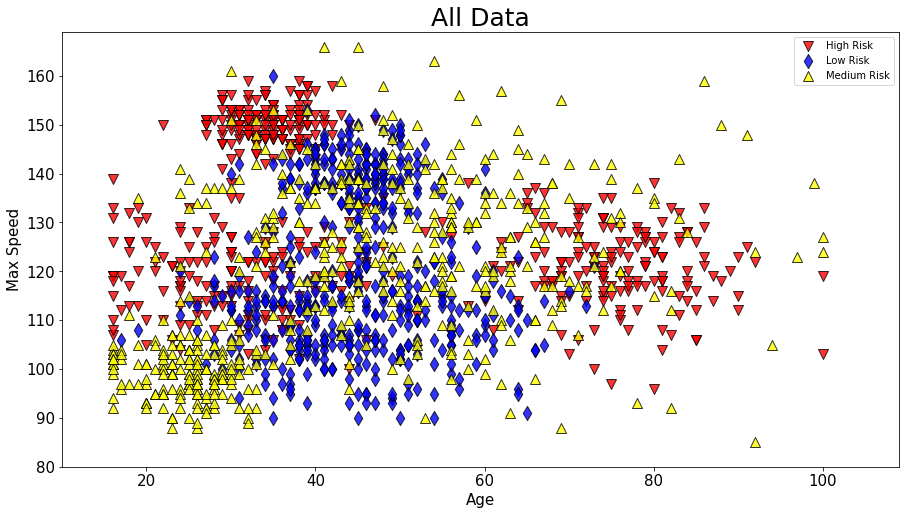

In [56]:
plotPrediction(None, X[:, 1], X[:, 0], 
               'Age', 'Max Speed', y,
                title="All Data");

In [57]:
# just two dimensions
X[:, :2]

array([[ 98.,  44.],
       [118.,  54.],
       [111.,  26.],
       ...,
       [138.,  41.],
       [100.,  31.],
       [100.,  58.]])

In [58]:
%%time

from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
clf.fit(X[:, :2], y)

CPU times: user 4.72 ms, sys: 47 µs, total: 4.77 ms
Wall time: 4.72 ms


In [59]:
input = [[100.0, 48.0]]
clf.predict(input)

array([1])

In [60]:
clf.predict_proba(input)

array([[0., 1., 0.]])

# Stop here

# Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization.jpg'>

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 3), (1200,), (300, 3), (300,))

In [62]:
assert X_train.shape == (len(X) * (1 - 0.2), 3)
assert y_train.shape == (len(X) * (1 - 0.2),) 
assert X_test.shape == (len(X) * 0.2, 3)
assert y_test.shape == (len(X) * 0.2, )

In [63]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

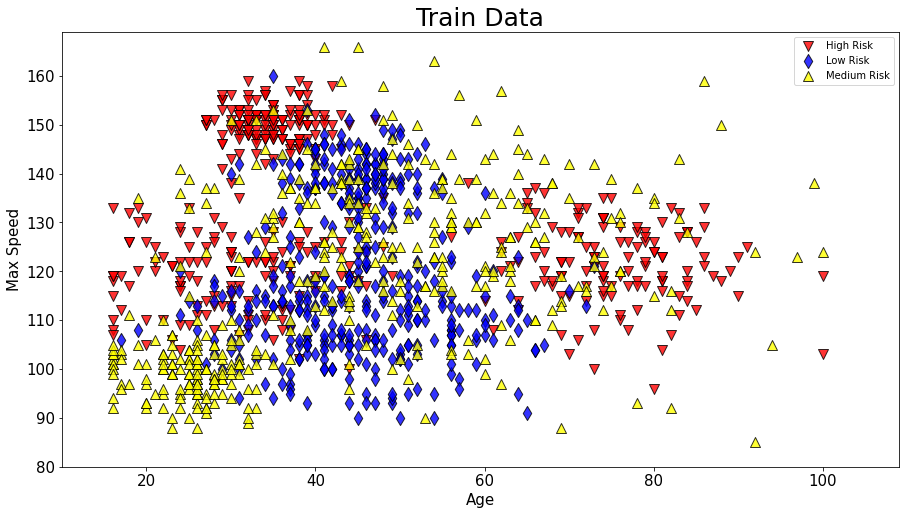

In [64]:
plotPrediction(None, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train, title="Train Data");

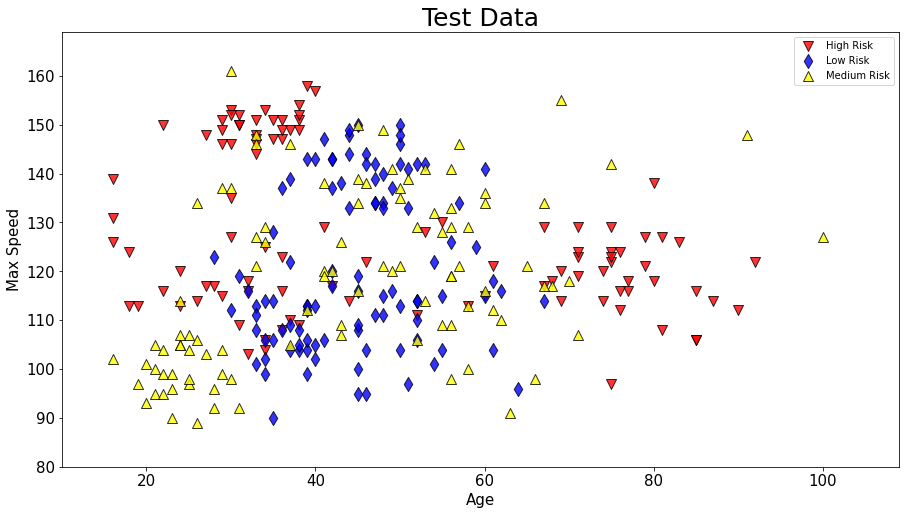

In [65]:
plotPrediction(None, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test, title="Test Data");

## What is the best split?

* assign a category to each node containing a certain set of samples
* use a metric (Gini or Entropy) to decide how good a node would be based on that category
* sum up weighted metric for both child nodes
* optimize the split for that summed metric

https://machinelearningmastery.com/classification-and-regression-trees-for-machine-learning/


In [66]:
clf = DecisionTreeClassifier()
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 4.33 ms, sys: 0 ns, total: 4.33 ms
Wall time: 4.02 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [67]:
# we perform at most 18 splits of our data until we make a decision where the data point belongs

clf.tree_.max_depth

18

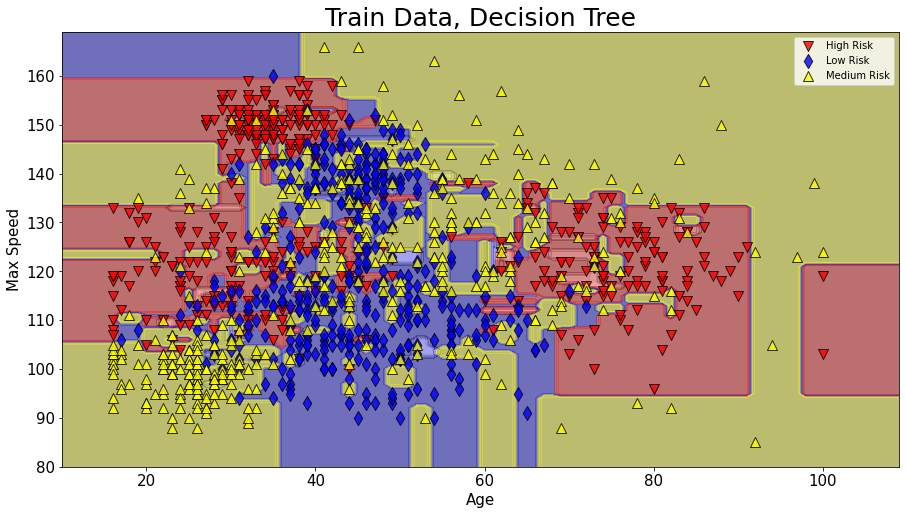

In [68]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Decision Tree");

In [69]:
clf.score(X_train_2_dim, y_train)

0.9425

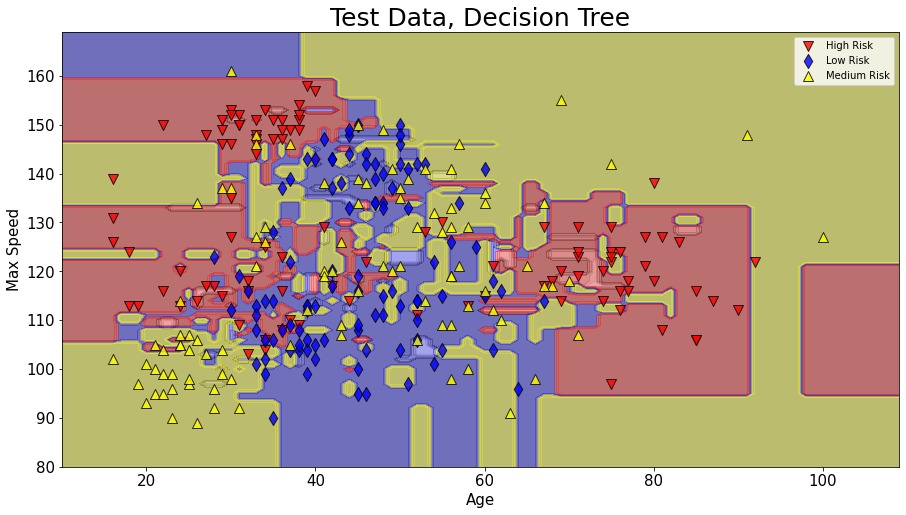

In [70]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Decision Tree");

In [71]:
clf.score(X_test_2_dim, y_test)

0.6066666666666667

# Exercise III: Getting your feet wet fighting overfitting

_fighit overfitting and underfitting: try to make score for training and test as similar as possible while keeping them high at the same time_

* play with the parameters for the decision trees
* what is their impact?
* what arw your best scores?

In [72]:
clf = DecisionTreeClassifier(
    random_state=42,
    max_depth=10,
    max_leaf_nodes=20,
    min_samples_leaf=10)
%time clf.fit(X_train_2_dim, y_train)

CPU times: user 2.37 ms, sys: 23 µs, total: 2.39 ms
Wall time: 2.4 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=20,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [73]:
clf.score(X_train_2_dim, y_train)

0.7308333333333333

In [74]:
clf.score(X_test_2_dim, y_test)

0.67

In [75]:
clf.tree_.max_depth

8

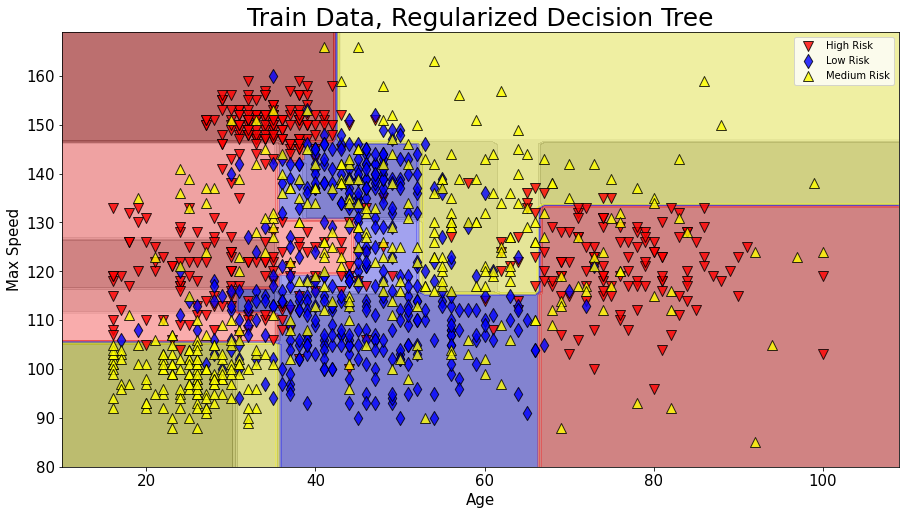

In [76]:
plotPrediction(clf, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data, Regularized Decision Tree");

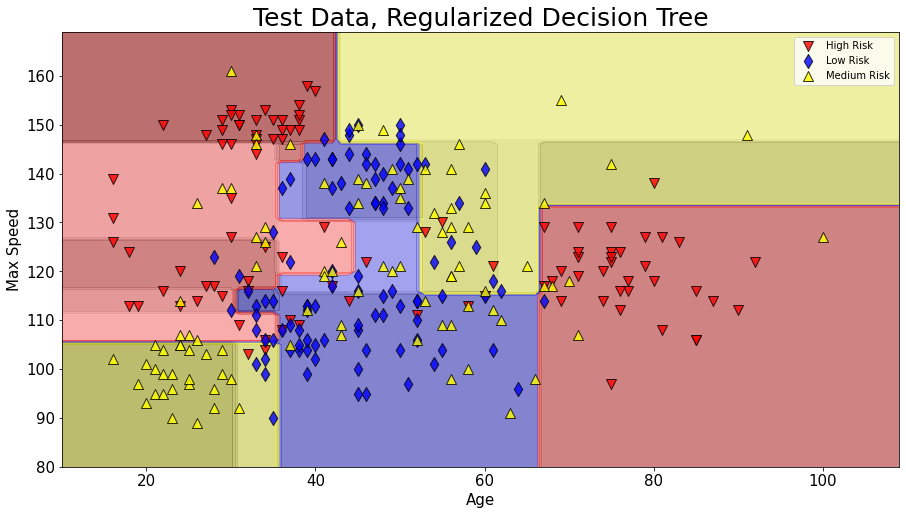

In [77]:
plotPrediction(clf, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data, Regularized Decision Tree");

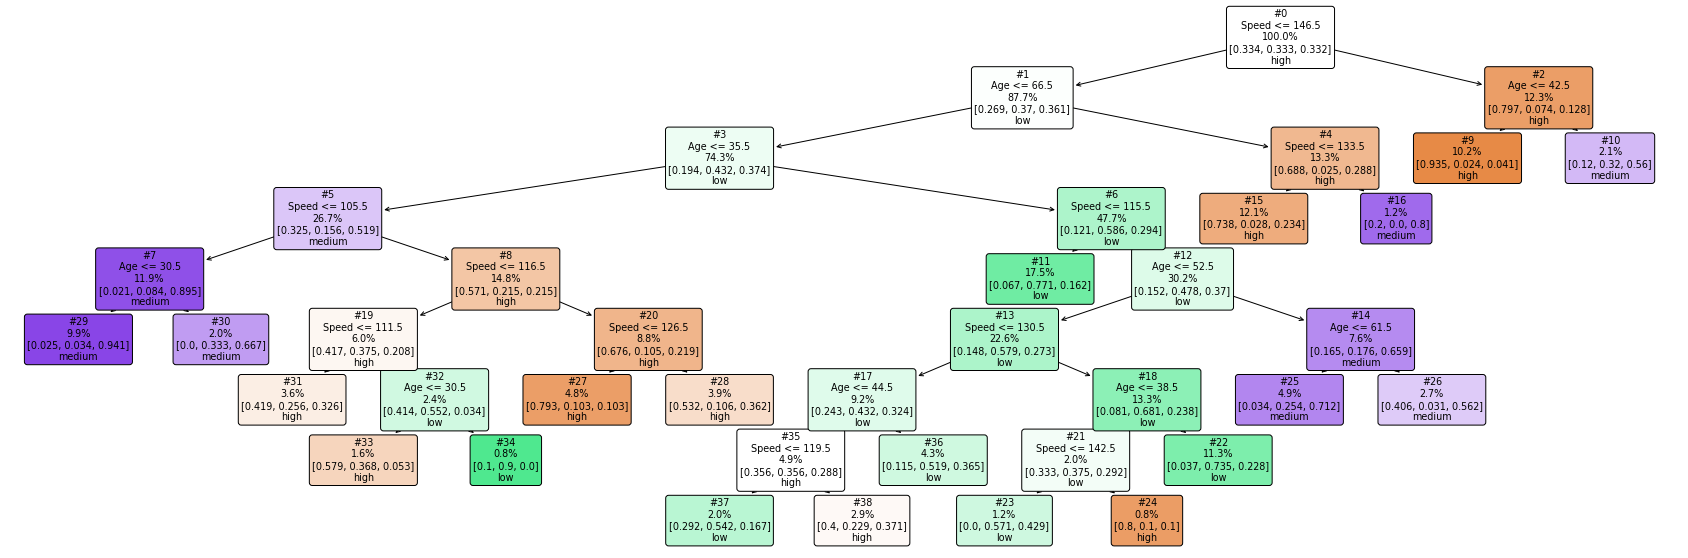

In [78]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

feature_names=['Speed', 'Age']
class_names=['high', 'low', 'medium']

plt.figure(figsize=(30, 10))
plot_tree(clf, 
          feature_names=feature_names,
          class_names=class_names,
          impurity=False,
          label='none',
          rounded=True,
          node_ids=True,
          proportion=True,
          filled=True);